In [1]:
# Unzip the problem files in case they are not ready
!python script.py

Iniciando script para descomprimir archivos .gz en: ALL_tsp\tar_gz

--- Resumen del Proceso ---
Archivos encontrados con extensión .gz: 144
Archivos descomprimidos con éxito: 144
Archivos que tuvieron errores: 0
Proceso de descompresión finalizado.

Los archivos finales se encuentran en ALL_tsp


In [13]:
import numpy as np
from EDAspy.optimization import UMDAc
import math
import time
import sys
import io

In [2]:
from load_data import symmetric_tsp_solutions

opt_solutions=symmetric_tsp_solutions().sort_index()

In [3]:
from load_data import load_problems,load_solutions

solutions=load_solutions()
problems=load_problems()

# Problem instances visualization

We are taking the problem instances with known optimal cost and known tour

In [4]:
known_tour_and_opt_cost_problems=opt_solutions[solutions.name[solutions.name.apply(lambda x: x in opt_solutions.index)]].sort_values()

In [5]:
problems_to_test=problems.set_index('name').loc[known_tour_and_opt_cost_problems.index]
problems_to_test['optimal_cost']=known_tour_and_opt_cost_problems

In [6]:
import tsplib95

# Relevant features
problems_to_test.file_paths.apply(tsplib95.load).apply(lambda x: x.type)
problems_to_test.file_paths.apply(tsplib95.load).apply(lambda x: x.dimension)
"""
Field to access when edge_weight_type is
- EUC_2D or GEO -> node_coords
- EXPLICIT      -> edge_weights
"""
field_to_access_map={'EUC_2D':'.node_coords','GEO':'.node_coords','EXPLICIT':'.edge_weights'}
# Execute to show the different representations:
# print(problems_to_test.file_paths.apply(tsplib95.load).apply(lambda x: x.edge_weight_type))

problems_with_solutions=solutions.set_index('name').join(problems_to_test,how='right',lsuffix='_solution',rsuffix='_problem').drop(columns=['type_problem','type_solution','size_solution']).rename({'size_problem':'size'},axis=1)
problems_with_solutions['problem_instance']=problems_with_solutions['file_paths_problem'].apply(tsplib95.load)
problems_with_solutions['solution_instance']=problems_with_solutions['file_paths_solution'].apply(tsplib95.load)
problems_with_solutions['edge_weight_type']=problems_with_solutions.problem_instance.apply(lambda x: x.edge_weight_type)
problems_with_solutions['problem_field_to_obtain_representation']=problems_with_solutions['edge_weight_type'].apply(lambda x: field_to_access_map[x])
problems_with_solutions['solution_representation']=problems_with_solutions['solution_instance'].apply(lambda x: x.tours[0])
def obtain_representation(problem_info):
    problem_instance=problem_info.problem_instance
    field=problem_info.problem_field_to_obtain_representation
    if field=='.node_coords':
        return problem_instance.node_coords
    else:
        return problem_instance.edge_weights
problems_with_solutions['problem_representation']=problems_with_solutions.apply(obtain_representation,axis=1)

# I'll just take the probls with EUC_2D representation
problems_with_solutions=problems_with_solutions[problems_with_solutions.edge_weight_type=='EUC_2D']
problems_with_solutions=problems_with_solutions[['optimal_cost','size','solution_representation','problem_representation']]

Available problems: ['st70', 'tsp225', 'rd100', 'lin105', 'pcb442', 'pr76', 'pr1002', 'pr2392']
Optimal cost: 14379


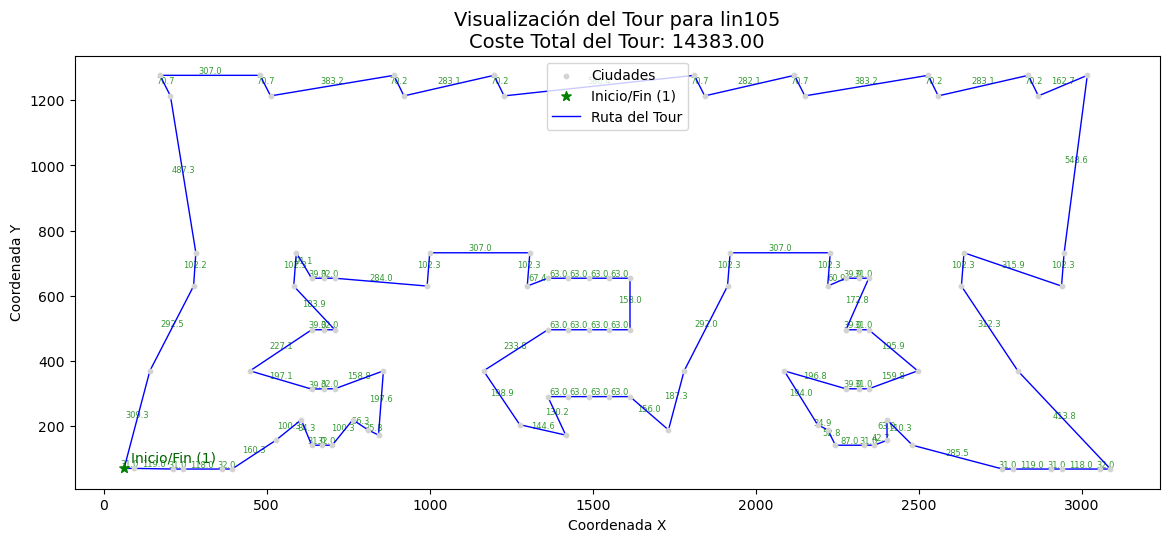

In [7]:
from displaying_results import drawing_tour
print('Available problems:',problems_with_solutions.index.tolist())
name='lin105'
cities=problems_with_solutions.loc[name].problem_representation
solution_tour=problems_with_solutions.loc[name].solution_representation
optimal_cost=problems_with_solutions.loc[name].optimal_cost
print(f'Optimal cost: {optimal_cost}')
drawing_tour(name,cities,solution_tour,True)

# Solving problem instance

In [44]:
def eda_solving_tsp(problem_input,size_gen=250,max_iter=1000,dead_iter=100,alpha=0.5,verbose=True):
    
    stdout_original = sys.stdout
    buffer = io.StringIO()

    try:
        if not verbose:
            sys.stdout=buffer
        city_coords_dict = problem_input

        city_ids = list(city_coords_dict.keys())
        coords_list = list(city_coords_dict.values())
        n_cities = len(city_ids)

        if verbose:
            print(f"Solving TSP for {n_cities} cities.")
            print("City IDs:", city_ids)

        # 2. Define the distance function
        def euclidean_distance(coord1, coord2):
            """Calculates the Euclidean distance between two points."""
            return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

        def decode_permutation(edaspy_vector):
            """
            Decodes a continuous vector into a permutation of city indices (0 to n_cities-1).
            The order is determined by sorting the original indices based on the vector values.
            """
            indexed_values = list(zip(edaspy_vector, range(n_cities)))

            sorted_indexed_values = sorted(indexed_values, key=lambda item: item[0])

            permutation_indices = [item[1] for item in sorted_indexed_values]

            return permutation_indices

        def tsp_cost_function(edaspy_vector):
            """
            Calculates the total distance of the tour represented by the EDAspy vector.
            The vector is first decoded into a city permutation.
            """
            permutation_indices = decode_permutation(edaspy_vector)

            total_dist = 0
            for i in range(n_cities - 1):
                city_idx_i = permutation_indices[i]
                city_idx_j = permutation_indices[i+1]
                coord_i = coords_list[city_idx_i]
                coord_j = coords_list[city_idx_j]
                total_dist += euclidean_distance(coord_i, coord_j)

            first_city_idx = permutation_indices[0]
            last_city_idx = permutation_indices[n_cities-1]
            coord_first = coords_list[first_city_idx]
            coord_last = coords_list[last_city_idx]
            total_dist += euclidean_distance(coord_last, coord_first)

            return total_dist

        umda = UMDAc(size_gen=size_gen, max_iter=max_iter, dead_iter=dead_iter, n_variables=n_cities,alpha=alpha,
                    lower_bound=0,upper_bound=n_cities)

        if verbose:
            print("\nRunning EDA (UMDAc) for TSP...")
        start_time = time.time()

        eda_result = umda.minimize(tsp_cost_function, False)

        end_time = time.time()
        best_cost = eda_result.best_cost
        best_edaspy_vector = eda_result.best_ind
        best_permutation_indices = decode_permutation(best_edaspy_vector)
        best_tour_city_ids = [city_ids[i] for i in best_permutation_indices]

        if verbose:
            print(f"\nEDA finished in {end_time - start_time:.2f} seconds.")

            print("\n--- EDA Results ---")
            print(f"Best cost (minimum total distance found): {best_cost:.4f}")
            print("Best tour found (sequence of city IDs):", best_tour_city_ids)
    finally:
        if not verbose:
            sys.stdout=stdout_original
    return best_tour_city_ids,best_cost,eda_result,(end_time - start_time)

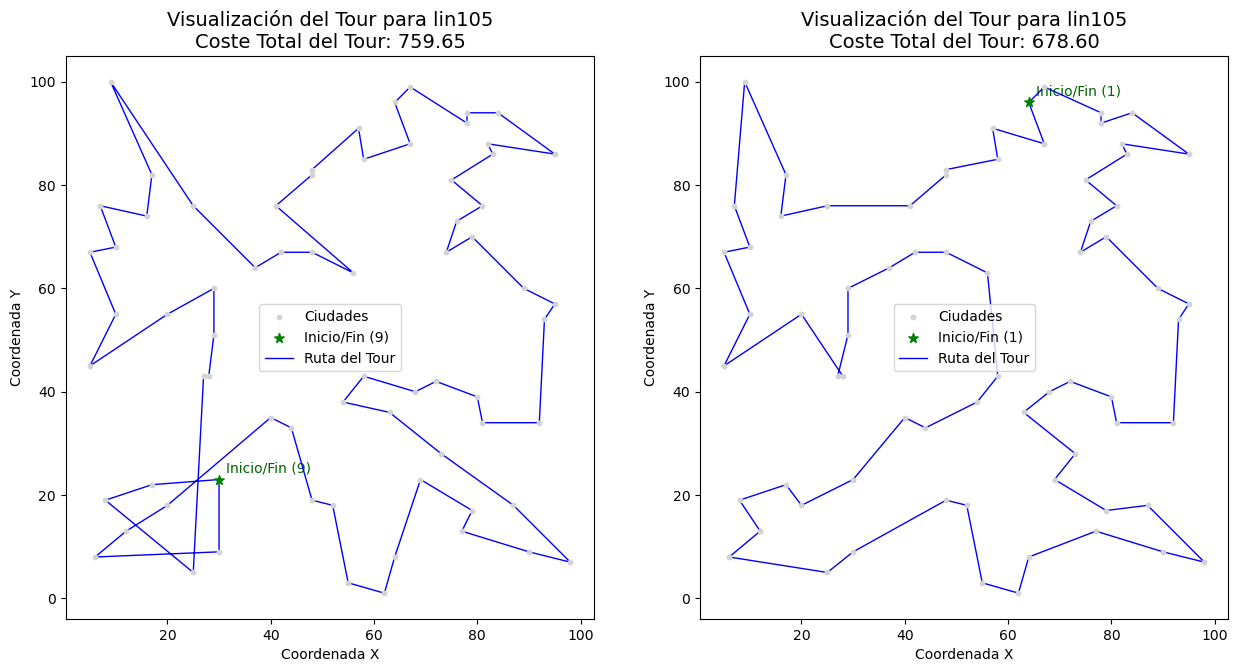

In [8]:
problem_to_solve='st70'
problem_input=problems_with_solutions.problem_representation[problem_to_solve]
optimal_solution=problems_with_solutions.solution_representation[problem_to_solve]
best_tour_city_ids,best_cost,eda_result,times=eda_solving_tsp(problem_input,verbose=False)

import matplotlib.pyplot as plt
_,axs=plt.subplots(1,2,figsize=(15,30))
ax=axs[0]
drawing_tour(name,problem_input,best_tour_city_ids,ax=ax)
ax=axs[1]
drawing_tour(name,problem_input,optimal_solution,ax=ax)

# Hyperparameter study
- size_gen
- alpha

In [31]:
problem_to_be_solved='st70'
problem_input=problems_with_solutions.problem_representation[problem_to_solve]
optimal_solution=problems_with_solutions.solution_representation[problem_to_solve]
optimal_cost=problems_with_solutions.optimal_cost[problem_to_solve]
best_tour_found,best_cost,eda_result,times=eda_solving_tsp(problem_input,verbose=False)

In [33]:
import pandas as pd

alpha_values=pd.Series([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
alpha_values.name='alpha'
size_gen_values=pd.Series([10,20,30,40,50,100,200,250]).astype(int)
size_gen_values.name='size_gen'
experiments=pd.DataFrame(index=alpha_values,columns=size_gen_values).unstack().reset_index()[['size_gen','alpha']].set_index(['size_gen','alpha'],drop=False)
results=experiments.apply(lambda x: eda_solving_tsp(problem_input,size_gen=int(x.size_gen),alpha=x.alpha,verbose=False),axis=1)
costs=results.apply(lambda x: x[1])
costs.name='cost'
histories=results.apply(lambda x: x[2].history)
histories.name='history'
times=results.apply(lambda x: x[3])
times.name='times'
results=pd.concat([costs,histories,times],axis=1)

In [34]:
results.to_csv('exploring_size_gen_alpha_st70.csv')

In [14]:
import pandas as pd
pd.read_csv('exploring_size_gen_alpha_st70.csv').set_index(['size_gen','alpha']).cost.to_csv('costs.csv')

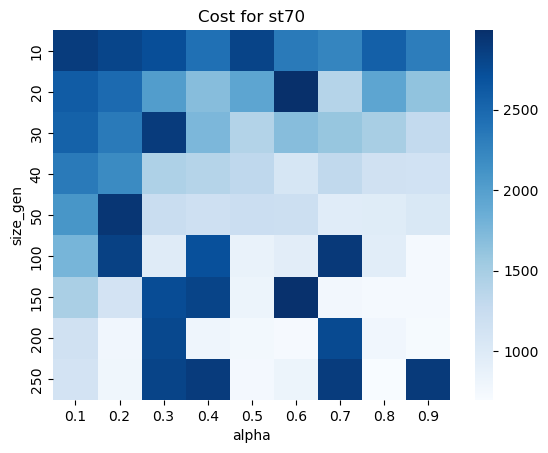

In [41]:
import seaborn as sns

_,ax=plt.subplots()
sns.heatmap(results.cost.unstack(),cmap='Blues')
ax.set_title(f'Cost for {problem_to_be_solved}')

plt.show()

# Problem growth comparison

In [98]:
problem_growth=problems_with_solutions.apply(lambda x: eda_solving_tsp(x.problem_representation,verbose=False),axis=1)

In [100]:
costs=problem_growth.apply(lambda x: x[1])
costs.name='cost'
histories=problem_growth.apply(lambda x: x[2].history)
histories.name='history'
times=problem_growth.apply(lambda x: x[3])
times.name='times'
results=pd.concat([costs,histories,times],axis=1)
results.to_csv('exploring_problem_growth_all_problems.csv')

In [18]:
problem_growth_results=pd.read_csv('exploring_problem_growth_all_problems.csv').set_index('problem_name')

,cost,optimal_cost
problem_name,,
st70,2.871627e+03,675
pr76,1.240539e+05,108159
rd100,1.110922e+04,7910
lin105,9.928823e+04,14379
tsp225,3.638874e+04,3916
pcb442,7.057163e+05,50778
pr1002,6.063035e+06,259045
pr2392,1.471834e+07,378032


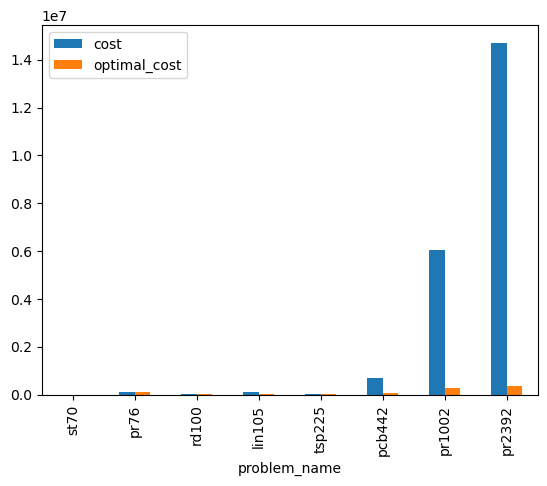

In [46]:
problem_growth_results.join(problems_with_solutions).sort_values(by='size')[['cost','optimal_cost']].plot(kind='bar')
problem_growth_results.join(problems_with_solutions).sort_values(by='size')[['cost','optimal_cost']]

# Comparación con otros EDAs

In [45]:
from EDAspy.optimization import EGNA,EMNA

def egna_solving_tsp(problem_input,size_gen=250,max_iter=1000,dead_iter=50,alpha=0.5,verbose=True):
    
    stdout_original = sys.stdout
    buffer = io.StringIO()

    try:
        if not verbose:
            sys.stdout=buffer
        city_coords_dict = problem_input

        city_ids = list(city_coords_dict.keys())
        coords_list = list(city_coords_dict.values())
        n_cities = len(city_ids)

        if verbose:
            print(f"Solving TSP for {n_cities} cities.")
            print("City IDs:", city_ids)

        def euclidean_distance(coord1, coord2):
            """Calculates the Euclidean distance between two points."""
            return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

        def decode_permutation(edaspy_vector):
            """
            Decodes a continuous vector into a permutation of city indices (0 to n_cities-1).
            The order is determined by sorting the original indices based on the vector values.
            """
            indexed_values = list(zip(edaspy_vector, range(n_cities)))

            sorted_indexed_values = sorted(indexed_values, key=lambda item: item[0])

            permutation_indices = [item[1] for item in sorted_indexed_values]

            return permutation_indices

        def tsp_cost_function(edaspy_vector):
            """
            Calculates the total distance of the tour represented by the EDAspy vector.
            The vector is first decoded into a city permutation.
            """
            permutation_indices = decode_permutation(edaspy_vector)

            total_dist = 0
            for i in range(n_cities - 1):
                city_idx_i = permutation_indices[i]
                city_idx_j = permutation_indices[i+1]
                coord_i = coords_list[city_idx_i]
                coord_j = coords_list[city_idx_j]
                total_dist += euclidean_distance(coord_i, coord_j)

            first_city_idx = permutation_indices[0]
            last_city_idx = permutation_indices[n_cities-1]
            coord_first = coords_list[first_city_idx]
            coord_last = coords_list[last_city_idx]
            total_dist += euclidean_distance(coord_last, coord_first)

            return total_dist

        umda = EGNA(size_gen=size_gen, max_iter=max_iter, dead_iter=dead_iter, n_variables=n_cities,alpha=alpha,
                    lower_bound=0,upper_bound=n_cities)

        if verbose:
            print("\nRunning EDA (EGNA) for TSP...")
        start_time = time.time()

        eda_result = umda.minimize(tsp_cost_function, True)

        end_time = time.time()
        best_cost = eda_result.best_cost
        best_edaspy_vector = eda_result.best_ind
        best_permutation_indices = decode_permutation(best_edaspy_vector)
        best_tour_city_ids = [city_ids[i] for i in best_permutation_indices]

        if verbose:
            print(f"\EGNA finished in {end_time - start_time:.2f} seconds.")

            print("\n--- EGNA Results ---")
            print(f"Best cost (minimum total distance found): {best_cost:.4f}")
            print("Best tour found (sequence of city IDs):", best_tour_city_ids)
    finally:
        if not verbose:
            sys.stdout=stdout_original
    return best_tour_city_ids,best_cost,eda_result,(end_time - start_time)

def emna_solving_tsp(problem_input,size_gen=250,max_iter=1000,dead_iter=100,alpha=0.5,verbose=True):
    
    stdout_original = sys.stdout
    buffer = io.StringIO()

    try:
        if not verbose:
            sys.stdout=buffer
        city_coords_dict = problem_input

        city_ids = list(city_coords_dict.keys())
        coords_list = list(city_coords_dict.values())
        n_cities = len(city_ids)

        if verbose:
            print(f"Solving TSP for {n_cities} cities.")
            print("City IDs:", city_ids)

        # 2. Define the distance function
        def euclidean_distance(coord1, coord2):
            """Calculates the Euclidean distance between two points."""
            return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

        def decode_permutation(edaspy_vector):
            """
            Decodes a continuous vector into a permutation of city indices (0 to n_cities-1).
            The order is determined by sorting the original indices based on the vector values.
            """
            indexed_values = list(zip(edaspy_vector, range(n_cities)))

            sorted_indexed_values = sorted(indexed_values, key=lambda item: item[0])

            permutation_indices = [item[1] for item in sorted_indexed_values]

            return permutation_indices

        def tsp_cost_function(edaspy_vector):
            """
            Calculates the total distance of the tour represented by the EDAspy vector.
            The vector is first decoded into a city permutation.
            """
            permutation_indices = decode_permutation(edaspy_vector)

            total_dist = 0
            for i in range(n_cities - 1):
                city_idx_i = permutation_indices[i]
                city_idx_j = permutation_indices[i+1]
                coord_i = coords_list[city_idx_i]
                coord_j = coords_list[city_idx_j]
                total_dist += euclidean_distance(coord_i, coord_j)

            first_city_idx = permutation_indices[0]
            last_city_idx = permutation_indices[n_cities-1]
            coord_first = coords_list[first_city_idx]
            coord_last = coords_list[last_city_idx]
            total_dist += euclidean_distance(coord_last, coord_first)

            return total_dist

        umda = EMNA(size_gen=size_gen, max_iter=max_iter, dead_iter=dead_iter, n_variables=n_cities,alpha=alpha,
                    lower_bound=0,upper_bound=n_cities)

        if verbose:
            print("\nRunning EDA (EMNA) for TSP...")
        start_time = time.time()

        eda_result = umda.minimize(tsp_cost_function, True)

        end_time = time.time()
        best_cost = eda_result.best_cost
        best_edaspy_vector = eda_result.best_ind
        best_permutation_indices = decode_permutation(best_edaspy_vector)
        best_tour_city_ids = [city_ids[i] for i in best_permutation_indices]

        if verbose:
            print(f"\EMNA finished in {end_time - start_time:.2f} seconds.")

            print("\n--- EMNA Results ---")
            print(f"Best cost (minimum total distance found): {best_cost:.4f}")
            print("Best tour found (sequence of city IDs):", best_tour_city_ids)
    finally:
        if not verbose:
            sys.stdout=stdout_original
    return best_tour_city_ids,best_cost,eda_result,(end_time - start_time)

In [60]:
import pandas as pd

alpha_values=pd.Series([0.3,0.4,0.5,0.6])
alpha_values.name='alpha'
size_gen_values=pd.Series([100,200,250]).astype(int)
size_gen_values.name='size_gen'
n_rep=3
repeats=pd.Series(range(n_rep))
repeats.name='repeat'

cols=['size_gen','alpha','repeat']
experiments=pd.DataFrame(index=alpha_values,columns=size_gen_values).unstack().reset_index()[['size_gen','alpha']].set_index(['size_gen','alpha'],drop=False)
experiments
sz_al=pd.DataFrame(index=alpha_values,columns=size_gen_values).unstack().index
pd.DataFrame(index=alpha_values,columns=size_gen_values).unstack()
experiments=pd.DataFrame(index=repeats,columns=sz_al).unstack()
experiments.index.name=tuple(cols)
experiments=experiments.reset_index(drop=False)[cols].set_index(cols,drop=False)[cols[:-1]]


problem_to_be_solved='st70'
problem_input=problems_with_solutions.problem_representation[problem_to_be_solved]
optimal_solution=problems_with_solutions.solution_representation[problem_to_be_solved]
optimal_cost=problems_with_solutions.optimal_cost[problem_to_be_solved]

# mock_results=experiments.apply(lambda x: eda_solving_tsp(problem_input,size_gen=int(x.size_gen),alpha=x.alpha,verbose=False),axis=1)

In [61]:
res={
    # 'egna':experiments.apply(lambda x: egna_solving_tsp(problem_input,size_gen=int(x.size_gen),alpha=x.alpha,verbose=True),axis=1),
    'emna':experiments.apply(lambda x: emna_solving_tsp(problem_input,size_gen=int(x.size_gen),alpha=x.alpha,verbose=False),axis=1),
    'umdac':experiments.apply(lambda x: eda_solving_tsp(problem_input,size_gen=int(x.size_gen),alpha=x.alpha,verbose=False),axis=1),
    }
res_cost=dict(zip(res.keys(),[exp.unstack().apply(lambda x: x.values[np.argmin([y[1] for y in x.values])][1],axis=1) for exp in res.values()]))
res_hist=dict(zip(res.keys(),[exp.unstack().apply(lambda x: x.values[np.argmin([y[1] for y in x.values])][2].history,axis=1) for exp in res.values()]))
costs=pd.DataFrame(res_cost)

c:\Users\Usuario\anaconda3\envs\edaspy-env\lib\site-packages\EDAspy\optimization\custom\probabilistic_models\multivariate_gaussian.py:42: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.random.multivariate_normal(self.pm_means, self.pm_cov, size)


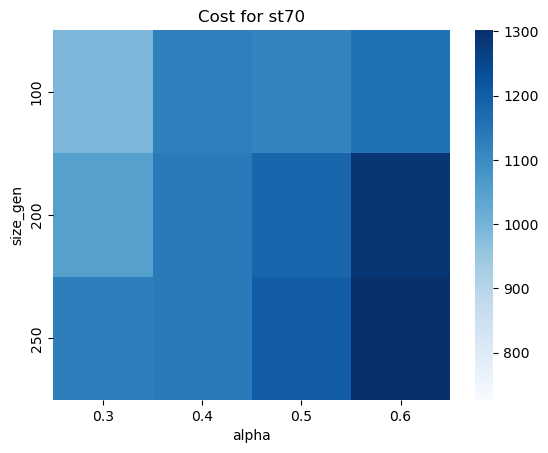

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

vmin=costs.min().min()
vmax=costs.max().max()

_,ax=plt.subplots()
sns.heatmap(costs.emna.unstack(),cmap='Blues',vmax=vmax,vmin=vmin)
ax.set_title(f'Cost for {problem_to_be_solved}')

plt.show()

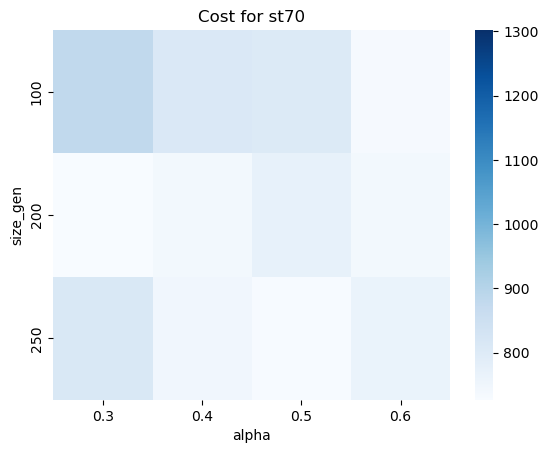

In [63]:
import seaborn as sns

_,ax=plt.subplots()
sns.heatmap(costs.umdac.unstack(),cmap='Blues',vmax=vmax,vmin=vmin)
ax.set_title(f'Cost for {problem_to_be_solved}')

plt.show()

# Cost obtained vs Optimal cost by size

In [20]:
problems_with_solutions

,optimal_cost,size,solution_representation,problem_representation
problem_name,,,,
st70,675,70,"[1, 36, 29, 13, 70, 35, 31, 69, 38, 59, 22, 66...","{1: [64, 96], 2: [80, 39], 3: [69, 23], 4: [72..."
tsp225,3916,225,"[1, 200, 198, 197, 195, 194, 218, 193, 196, 19...","{1: [155.42, 150.65], 2: [375.92, 164.65], 3: ..."
rd100,7910,100,"[1, 18, 62, 87, 15, 63, 86, 97, 67, 13, 49, 21...","{1: [143.775, 862.63], 2: [881.78, 1.18319], 3..."
lin105,14379,105,"[1, 2, 6, 7, 10, 11, 15, 103, 21, 22, 29, 30, ...","{1: [63, 71], 2: [94, 71], 3: [142, 370], 4: [..."
pcb442,50778,442,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{1: [200.0, 400.0], 2: [200.0, 500.0], 3: [200..."
pr76,108159,76,"[1, 76, 75, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...","{1: [3600, 2300], 2: [3100, 3300], 3: [4700, 5..."
pr1002,259045,1002,"[1, 2, 5, 3, 4, 6, 7, 8, 9, 10, 11, 12, 63, 64...","{1: [1150, 4000], 2: [1050, 2750], 3: [1150, 2..."
pr2392,378032,2392,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{1: [1639.0, 2156.0], 2: [1875.0, 2925.0], 3: ..."


In [19]:
problem_growth_results

,cost,history,times
problem_name,,,
st70,2.871627e+03,"[3172.6344733424353, 2934.313910799407, 3187.0...",4.519811
tsp225,3.638874e+04,"[37541.66565015397, 38079.8667315942, 37549.42...",8.316034
rd100,1.110922e+04,"[48537.02193164818, 49882.244818581275, 50177....",29.244926
lin105,9.928823e+04,"[109124.47062838548, 107523.41996438504, 10717...",5.502802
pcb442,7.057163e+05,"[725977.8844821412, 728307.9361839197, 729496....",39.778160
pr76,1.240539e+05,"[496667.53290183045, 511475.9195682282, 491911...",12.457927
pr1002,6.063035e+06,"[6184334.2493857425, 6198957.776947828, 622583...",78.481698
pr2392,1.471834e+07,"[14862244.41962339, 14895707.270110356, 149464...",91.833174
